# Pyphasefield

### Installation Requirements

* numpy (pip install numpy)
* matplotlib (pip install matplotlib)
* meshio (pip install meshio)
* (recommended) pycalphad (conda install -c pycalphad -c conda-forge pycalphad)
* (recommended) cudatoolkit (conda install cudatoolkit)
* (recommended) numba (conda install numba)

### Code Format

- pyphasefield
    - Engines
        - Cahn-Allen.py
        - Cahn-Hilliard.py
        - Diffusion.py
        - Dorr2010.py
        - Warren1995.py
        - Karma2001.py
        - NComponent.py
        - NCGPU.py
    - tests
    - examples
    - field.py
    - simulation.py
    - ppf_utils.py
    - ppf_gpu_utils.py
    
pyphasefield/Engines/Cahn-Allen.py: Implementation of Cahn-Allen non-conserved phase field model

pyphasefield/Engines/Cahn-Hilliard.py: Implementation of Cahn-Hilliard conserved phase field model

pyphasefield/Engines/Diffusion.py: Implementation of simple diffusion phase field model

pyphasefield/Engines/Dorr2010.py: Implementation of fully-explicit version of the phase field model from Dorr2010 paper, "A numerical algorithm for the solution of a phase-field model of polycrystalline materials"

pyphasefield/Engines/Warren1995.py: Implementation of the phase field model from Warren1995 paper, "Prediction of Dendritic Growth and Microsegregation Patterns in a Binary Alloy using the Phase-Field Method"

pyphasefield/Engines/Karma2001.py: Implementation of the phase field model from Karma2001 paper, "Phase-Field Formulation for Quantitative Modeling of Alloy Solidification"

pyphasefield/Engines/NComponent.py: Implementation of our N-Component, 2-phase polycrystalline phase field model

pyphasefield/Engines/NCGPU.py: Implementation of our N-Component, 2-phase polycrystalline phase field model using numba to run on a GPU

pyphasefield/field.py: Implementation of the Field class, which stores the field name, and data at each point

pyphasefield/simulation.py: Implementation of the Simulation class, which runs a simulation and allows access to the data from the simulation

pyphasefield/ppf_utils.py: Utility functions for pyphasefield

pyphasefield/ppf_gpu_utils.py: Utility functions specifically for GPU codes, including general-purpose GPU kernels

pyphasefield/tests: pytest files

pyphasefield/examples: example python scripts


### Examples

These are implementations of the example python scripts in the pyphasefield/examples folder, slightly modified to be usable in a ipynb cell

diffusion_example.py:

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf

sim = ppf.Simulation("data/diffusion_test")
sim.init_sim_Diffusion([20])
sim.plot_simulation()
sim.simulate(100)
sim.save_simulation()
sim.plot_simulation()

Example for DiffusionGPU engine:

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf

sim = ppf.Simulation("data/diffusionGPU_test")
sim.init_sim_DiffusionGPU([200, 200], cuda_blocks=(16,16), cuda_threads_per_block=(256,1))
sim.send_fields_to_GPU()
sim.plot_simulation()
sim.simulate(1000)
sim.save_simulation()
sim.plot_simulation()

warren1995_example.py:

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf
import matplotlib.pyplot as plt

sim = ppf.Simulation(save_path="data/warren1995_test")
sim.init_sim_Warren1995([200, 200], diamond_size=10)
sim.plot_simulation()
for i in range(10):
    sim.simulate(50)
    print(str((i+1)*10)+"% done!")
sim.plot_simulation()

NComponent_example.py (requires pycalphad):

In [ ]:
import sys
sys.path.insert(0,"..")
import numpy as np
import pyphasefield as ppf

saveloc = input("What folder in data to save under? ")
sim = ppf.Simulation(save_path="data/"+saveloc)
sim.init_sim_NComponent(dim=[200, 200], tdb_path="examples/Ni-Cu_Ideal.tdb", sim_type="seed", initial_temperature=1574, initial_concentration_array=[0.3937])
initial_step = int(input("What step to load from? (-1 = new simulation) "))
if(initial_step == -1):
    sim.save_simulation()
else:
    sim.load_simulation(step=initial_step)
sim._time_steps_per_checkpoint = 1000
sim._boundary_conditions_type = ["periodic", "periodic"]
sim.fields[1].data[:] = np.cos(np.pi/8)
sim.fields[2].data[:] = np.sin(np.pi/8)

totalsteps = int(input("How many steps to run? (10000 for a decent sized dendrite, ~10 minutes) "))
progress_bar_steps=int(totalsteps/20)
for i in range(20):
    sim.simulate(progress_bar_steps)
    print(str((i+1)*progress_bar_steps)+" steps completed out of "+str(totalsteps))
sim.simulate(totalsteps-20*progress_bar_steps)
print("Completed!")

sim.plot_simulation()

NCGPU example (requires pycalphad, numba, and cudatoolkit):

In [ ]:
import sys
sys.path.insert(0,"..")
import numpy as np
import pyphasefield as ppf


saveloc = input("What folder in data to save under?")
sim = ppf.Simulation(save_path="data/"+saveloc)
sim.init_sim_NCGPU(dim=[200, 200], tdb_path="examples/Ni-Cu_Ideal.tdb", sim_type="seed", initial_temperature=1574, initial_concentration_array=[0.3937])
initial_step = int(input("What step to load from? (-1 = new simulation)"))
if(initial_step == -1):
    sim.save_simulation()
else:
    sim.load_simulation(step=initial_step)
sim._time_steps_per_checkpoint = 1000
sim._boundary_conditions_type = ["periodic", "periodic"]
sim.fields[1].data[:] = np.cos(np.pi/8)
sim.fields[2].data[:] = np.sin(np.pi/8)

totalsteps = int(input("How many steps to run? (10000 for a decent sized dendrite)"))
progress_bar_steps=int(totalsteps/20)

#only significant difference between the codes - need to send data to the GPU
sim.send_fields_to_GPU()

for i in range(20):
    sim.simulate(progress_bar_steps)
    print(str((i+1)*progress_bar_steps)+" steps completed out of "+str(totalsteps))
sim.simulate(totalsteps-20*progress_bar_steps)
print("Completed!")

sim.plot_simulation()

#slight differences will be observed due to different discretization schemes used in GPU version at present

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield as ppf

sim = ppf.Simulation("save_path")
sim.init_sim_NCGPU(dim=[200, 200], 
                   tdb_path="examples/Ni-Cu_Ideal.tdb", 
                   sim_type="seed", 
                   initial_concentration_array=[0.3937]
                  )
sim._time_steps_per_checkpoint = 1000
sim.send_fields_to_GPU()
sim.simulate(10000)
sim.plot_simulation(save_images=True)


In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
dir(engines)

In [ ]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines


sim = engines.Diffusion(dimensions=[200, 200])

#initialize non-array parameters
sim.set_framework("CPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(1.)
sim.set_dt(0.1)
sim.set_time_step_counter(0)
sim.set_temperature_type(None) #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(None)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units(None)
sim.set_tdb_path(None)
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("PERIODIC")

data = {
    "D":1.
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(2000)
sim.plot_simulation(save_images=False)

self.user_data["melt_angle"] not defined, defaulting to 0
self.user_data["melt_angle"] not defined, defaulting to pi/4


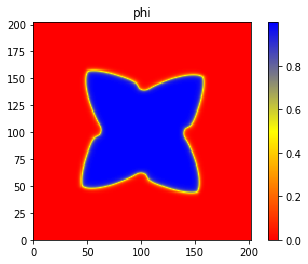

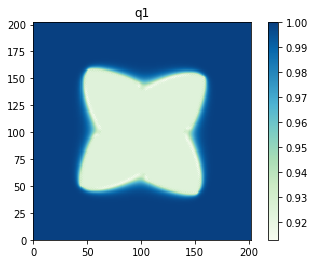

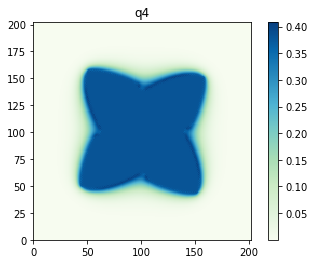

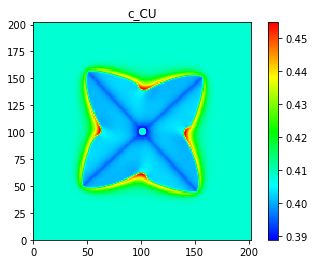

In [2]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt


sim = engines.AnisoDorrGPU(dimensions=[200, 200])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path(None)
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.40831]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(5000)
sim.plot_simulation(interpolation="nearest", save_images=False)

No module named 'pyphasefield.utils'
expected an indented block (Template.py, line 19)


C:\Users\scott\anaconda3\lib\site-packages\pycalphad\io\tdb.py:965: UserWarning: The type definition character `%` was defined in the following phases: ['FCC_A1', 'LIQUID'], but no corresponding TYPE_DEFINITION line was found in the TDB.
  warnings.warn(f"The type definition character `{typechar}` was defined in the following phases: "


self.user_data["melt_angle"] not defined, defaulting to 0
self.user_data["melt_angle"] not defined, defaulting to pi/4


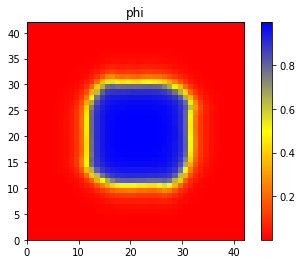

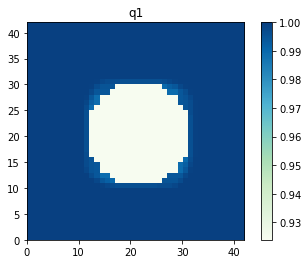

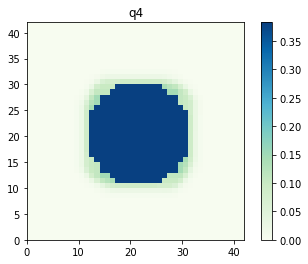

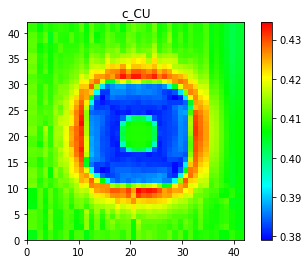

In [1]:
import sys
sys.path.insert(0,"..")
import pyphasefield.Engines as engines
import matplotlib.pyplot as plt


sim = engines.NCGPU(dimensions=[40, 40])

#initialize non-array parameters
sim.set_framework("GPU_SERIAL") #"CPU_SERIAL", "GPU_SERIAL"
sim.set_dx(0.0000046)
sim.set_time_step_counter(0)
sim.set_temperature_type("ISOTHERMAL") #None, "ISOTHERMAL", "LINEAR_GRADIENT", "XDMF_FILE"
sim.set_temperature_initial_T(1574.)
sim.set_temperature_dTdx(None)
sim.set_temperature_dTdy(None)
sim.set_temperature_dTdz(None)
sim.set_temperature_dTdt(None)
sim.set_temperature_path(None)
sim.set_temperature_units("K")
sim.set_tdb_path("tests/Ni-Cu_Ideal.tdb")
sim.set_tdb_phases(None)
sim.set_tdb_components(None)
sim.set_save_path(None)
sim.set_autosave_flag(False)
sim.set_autosave_save_images_flag(False)
sim.set_autosave_rate(100000)
sim.set_boundary_conditions("NEUMANN")

data = {
    "d_ratio":1.1,
    "sim_type":"seed",
    "initial_concentration_array":[0.40831]
}
sim.set_user_data(data)

#initialize simulation arrays, all parameter changes should be BEFORE this point!
sim.initialize_fields_and_imported_data()

#change array data here, for custom simulations


#run simulation
sim.simulate(1000)
sim.plot_simulation(interpolation="nearest", save_images=False)

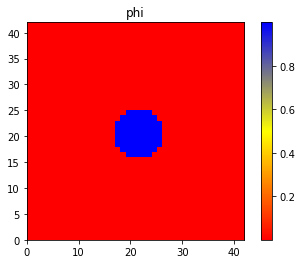

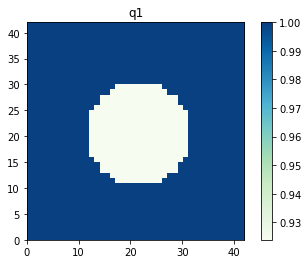

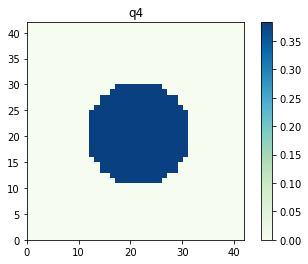

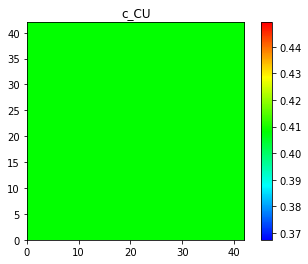

In [4]:
sim.simulate(1000)
sim.plot_simulation(interpolation="nearest", save_images=False)